In [3]:
import os
import time
import os
import time
import torch
import clip
import faiss
import psutil
import GPUtil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import hdbscan

CONFIGURATION


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPS = 0.3  # Adjust for DBSCAN
MIN_SAMPLES = 2  # Minimum cluster size
BATCH_SIZE = 64  # Number of images processed per batch
NUM_SAMPLES = 1000  # Number of images to process


FUNCTION TO TRACK RESOURCE USAGE

In [5]:
def print_system_usage():
    """Print CPU, memory, and GPU usage."""
    cpu_percent = psutil.cpu_percent()
    mem_info = psutil.virtual_memory()
    mem_percent = mem_info.percent
    gpu_percent = None
    gpu_mem_used = None
    
    if DEVICE == "cuda":
        gpus = GPUtil.getGPUs()
        if gpus:
            gpu_percent = gpus[0].load * 100  # GPU usage percentage
            gpu_mem_used = gpus[0].memoryUsed  # GPU memory usage in MB

    print(f"CPU Usage: {cpu_percent}% | Memory Usage: {mem_percent}%")
    if gpu_percent is not None:
        print(f"GPU Usage: {gpu_percent:.2f}% | GPU Memory Used: {gpu_mem_used}MB")



LOAD CLIP MODEL

In [6]:
print("Loading CLIP model...")
start_time = time.time()
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
print(f"CLIP model loaded in {time.time() - start_time:.2f} seconds.")
print_system_usage()

Loading CLIP model...
CLIP model loaded in 2.40 seconds.
CPU Usage: 3.9% | Memory Usage: 89.3%


FUNCTION TO GET IMAGE EMBEDDINGS


In [7]:
def get_clip_embedding(image):
    """Extract CLIP embedding for an image"""
    image = preprocess(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        embedding = model.encode_image(image).cpu().numpy()
    return embedding.squeeze()


LOAD FASHION-MNIST DATASET

In [8]:
print("Loading Fashion-MNIST dataset...")
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel for CLIP
    transforms.Resize((224, 224)),  # CLIP requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
fashion_mnist = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=NUM_SAMPLES, shuffle=True)

# Get a batch of images
images, labels = next(iter(data_loader))
images = images[:NUM_SAMPLES]  # Use a subset
labels = labels[:NUM_SAMPLES]

# Convert to list of PIL images
image_list = [transforms.ToPILImage()(img) for img in images]

print(f"Loaded {NUM_SAMPLES} images from Fashion-MNIST.")
print_system_usage()

Loading Fashion-MNIST dataset...
Loaded 1000 images from Fashion-MNIST.
CPU Usage: 7.1% | Memory Usage: 95.5%


In [9]:
print("Extracting embeddings...")
start_time = time.time()
embeddings = np.array([get_clip_embedding(img) for img in image_list])
print(f"Embeddings extracted in {time.time() - start_time:.2f} seconds.")
print_system_usage()

Extracting embeddings...
Embeddings extracted in 109.58 seconds.
CPU Usage: 4.6% | Memory Usage: 91.3%


CLUSTERING USING different methods; could change depending on dataset size

In [10]:
print(f"Clustering {NUM_SAMPLES} images using DBSCAN...")
start_time = time.time()

# Normalize embeddings before clustering
scaled_embeddings = StandardScaler().fit_transform(embeddings)

Clustering 1000 images using DBSCAN...


In [11]:

# Apply DBSCAN + cosine similarity
# Compute Cosine Similarity Matrix
# cosine_sim_matrix = cosine_similarity(embeddings)
# Convert similarity to distance (ensure values are non-negative)
# distance_matrix = 1 - cosine_sim_matrix
# distance_matrix = np.clip(distance_matrix, 0, 1)  # Fix negative values
# Apply DBSCAN with precomputed distances
# dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric="precomputed")
# labels = dbscan.fit_predict(distance_matrix)

In [12]:
#Apply just DBSCAN
# dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='euclidean')
# labels = dbscan.fit_predict(scaled_embeddings)

In [13]:
#Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric="euclidean")
labels = clusterer.fit_predict(embeddings)

In [14]:
# Get number of clusters (excluding noise)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN found {num_clusters} clusters in {time.time() - start_time:.2f} seconds.")
print_system_usage()

DBSCAN found 33 clusters in 0.73 seconds.
CPU Usage: 6.1% | Memory Usage: 91.6%


In [15]:
clusters = {}
for idx, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(image_list[idx])

DISPLAY CLUSTERED IMAGES

In [16]:
def display_cluster_images(cluster_id, max_images=10):
    """Display images from a given cluster"""
    if cluster_id == -1:
        print("Displaying outliers (images that didn't fit into a cluster):")
    else:
        print(f"Displaying images for Cluster {cluster_id}:")
    
    images = clusters[cluster_id][:max_images]  # Limit number of images displayed
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title(f"Cluster {cluster_id}")
        ax.axis("off")
    
    plt.show()

Displaying images for Cluster 31:


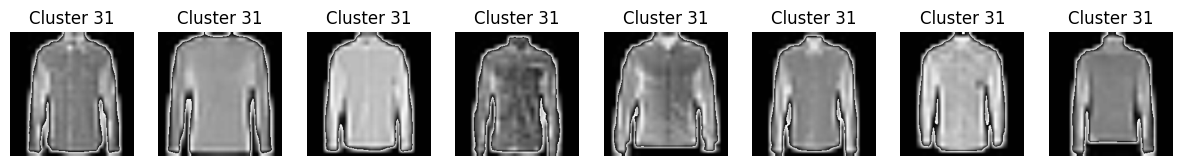

Displaying outliers (images that didn't fit into a cluster):


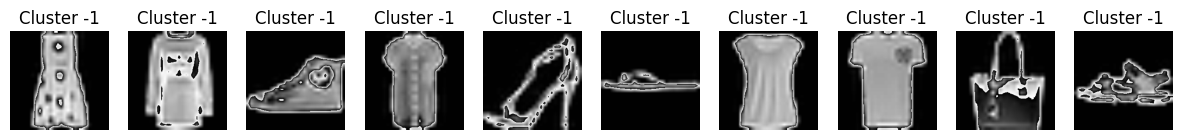

Displaying images for Cluster 25:


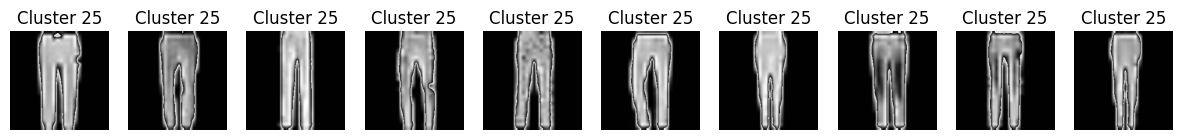

Displaying images for Cluster 22:


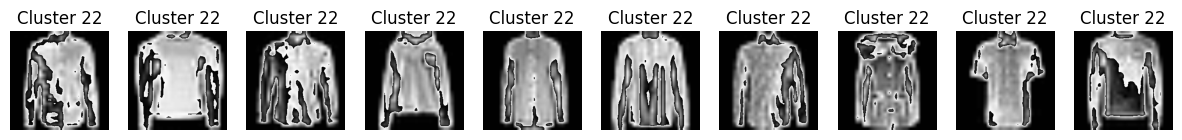

Displaying images for Cluster 29:


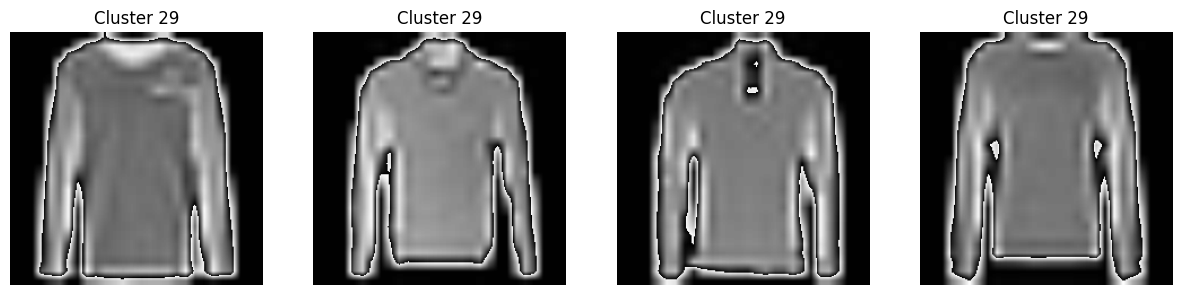

Displaying images for Cluster 27:


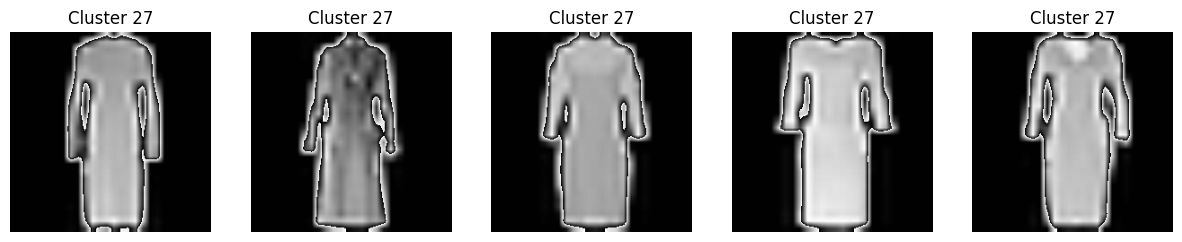

Displaying images for Cluster 10:


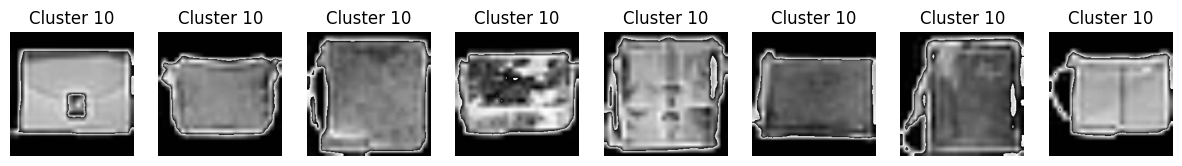

Displaying images for Cluster 20:


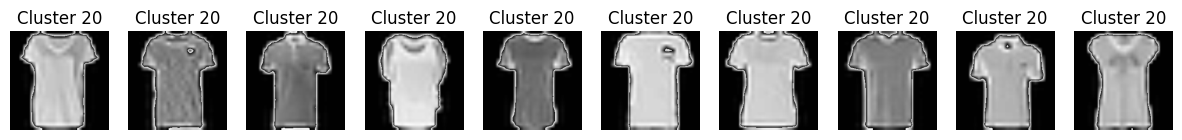

Displaying images for Cluster 19:


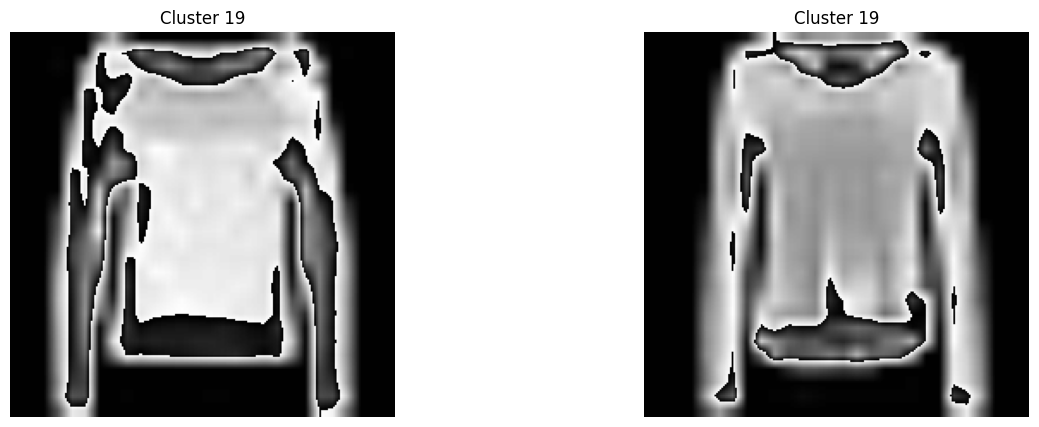

Displaying images for Cluster 7:


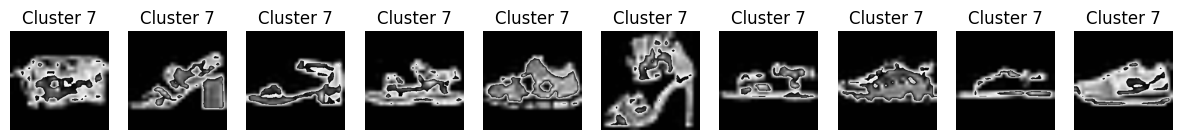

Displaying images for Cluster 12:


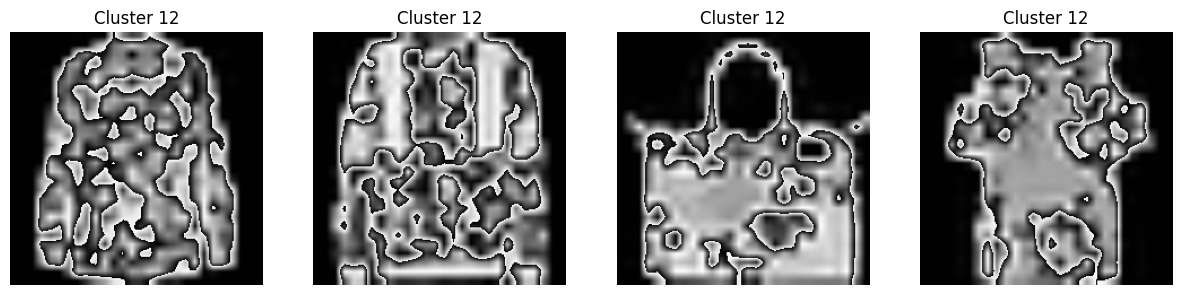

Displaying images for Cluster 11:


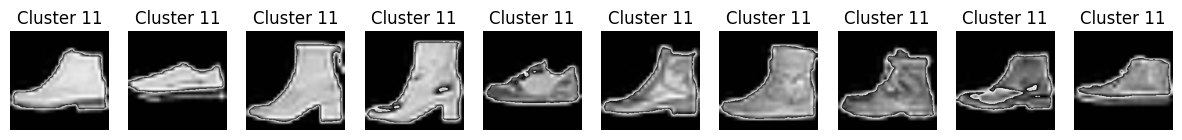

Displaying images for Cluster 16:


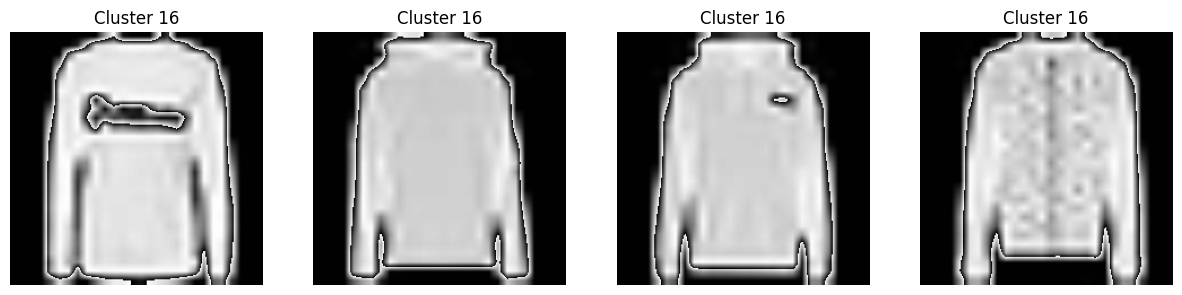

Displaying images for Cluster 18:


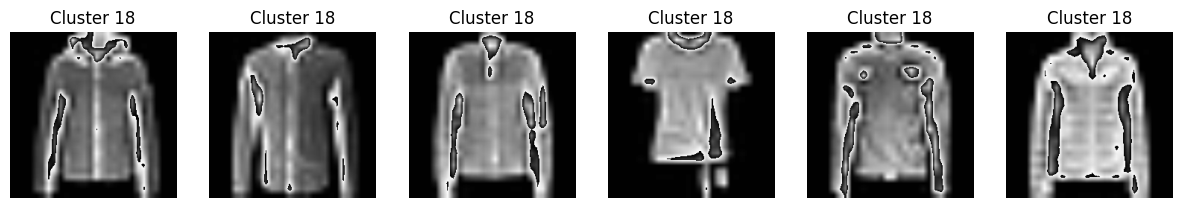

Displaying images for Cluster 9:


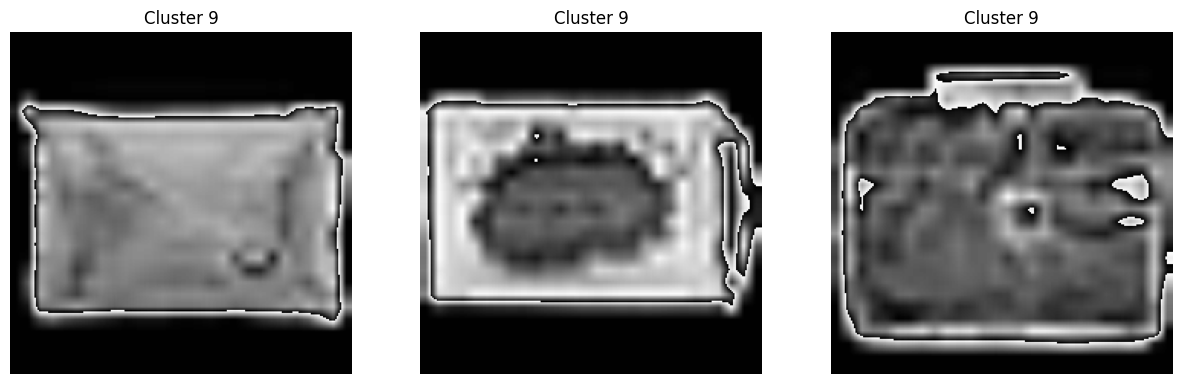

Displaying images for Cluster 30:


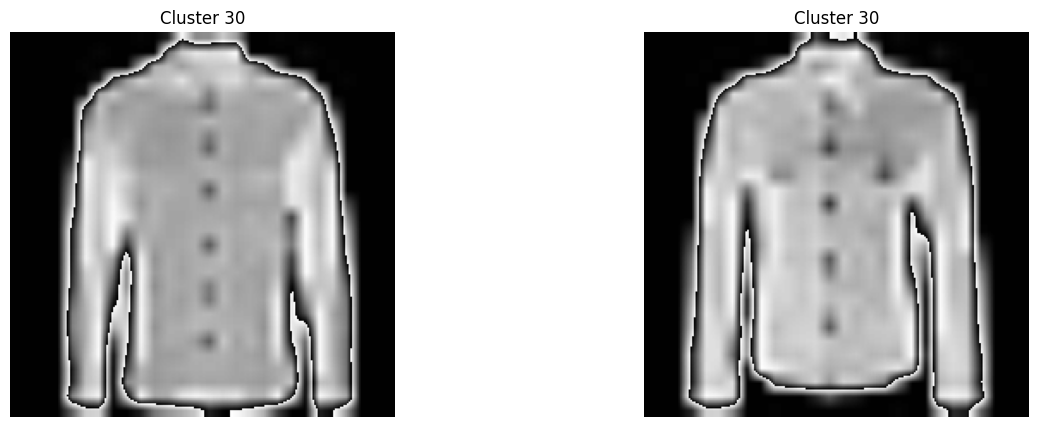

Displaying images for Cluster 15:


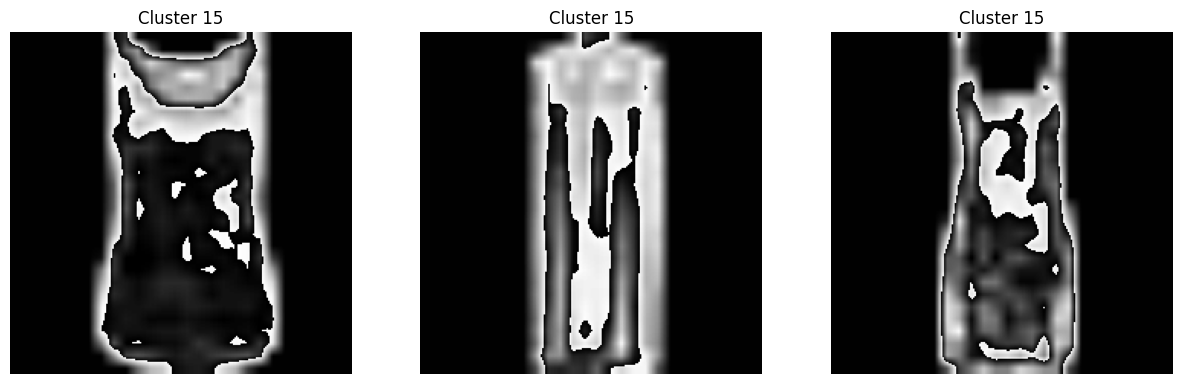

Displaying images for Cluster 17:


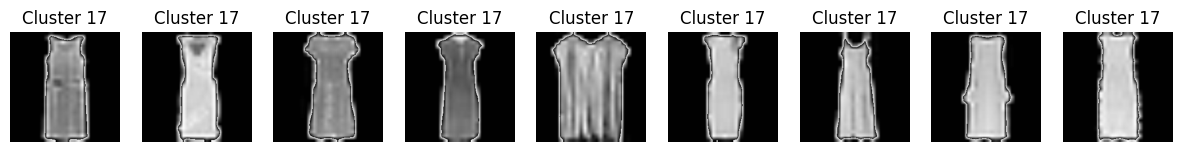

Displaying images for Cluster 1:


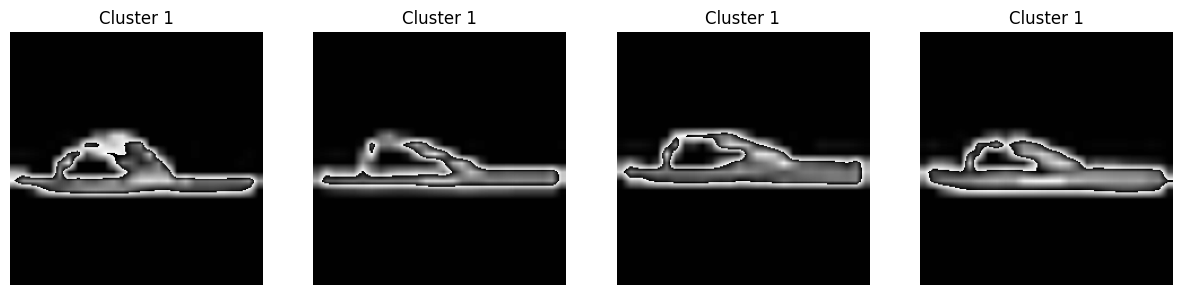

Displaying images for Cluster 4:


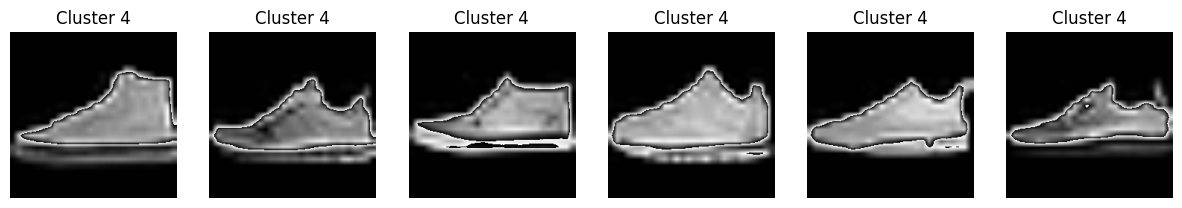

Displaying images for Cluster 26:


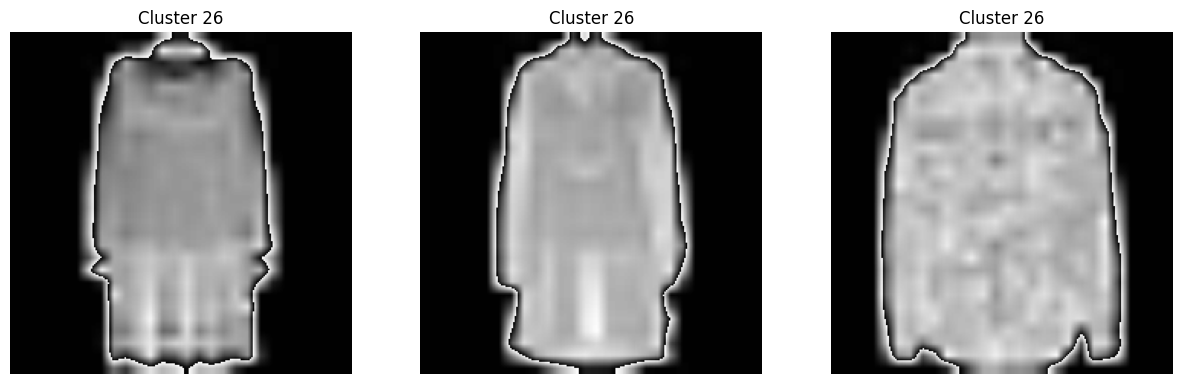

Displaying images for Cluster 21:


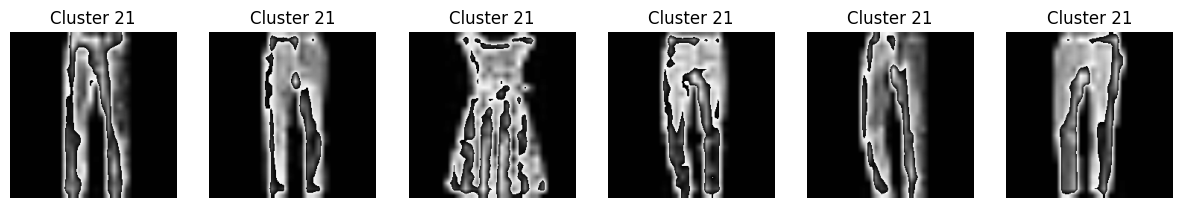

Displaying images for Cluster 14:


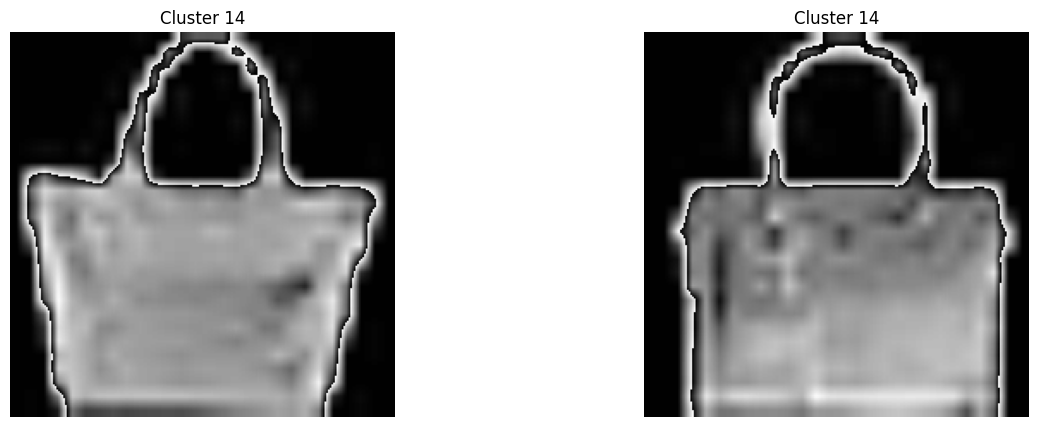

Displaying images for Cluster 6:


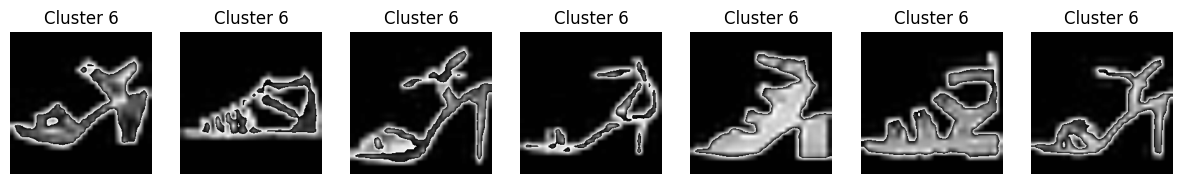

Displaying images for Cluster 2:


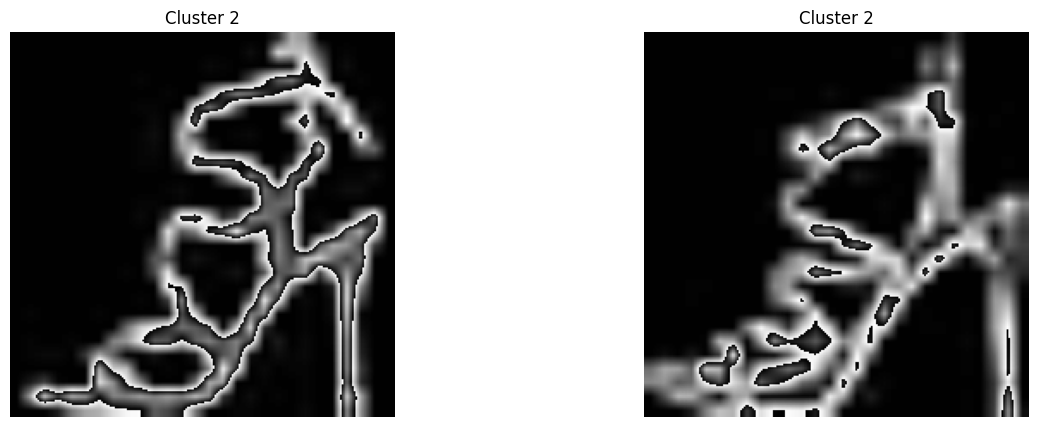

Displaying images for Cluster 32:


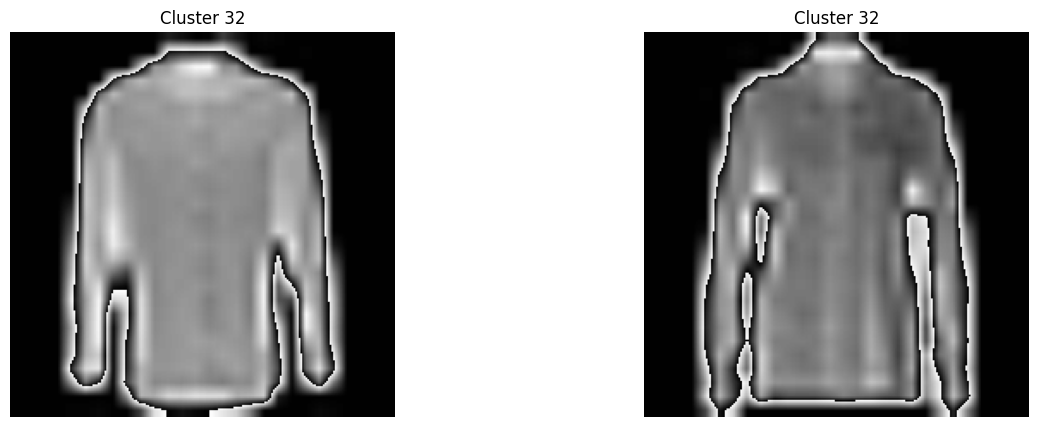

Displaying images for Cluster 0:


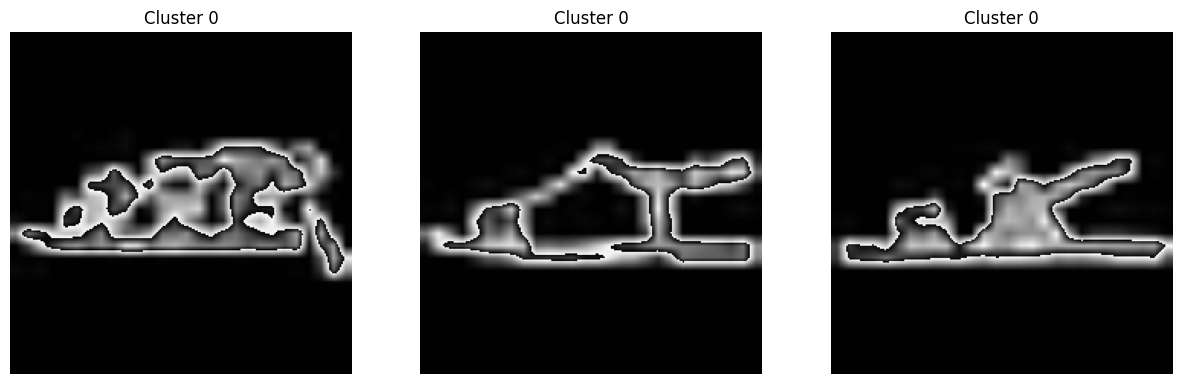

Displaying images for Cluster 8:


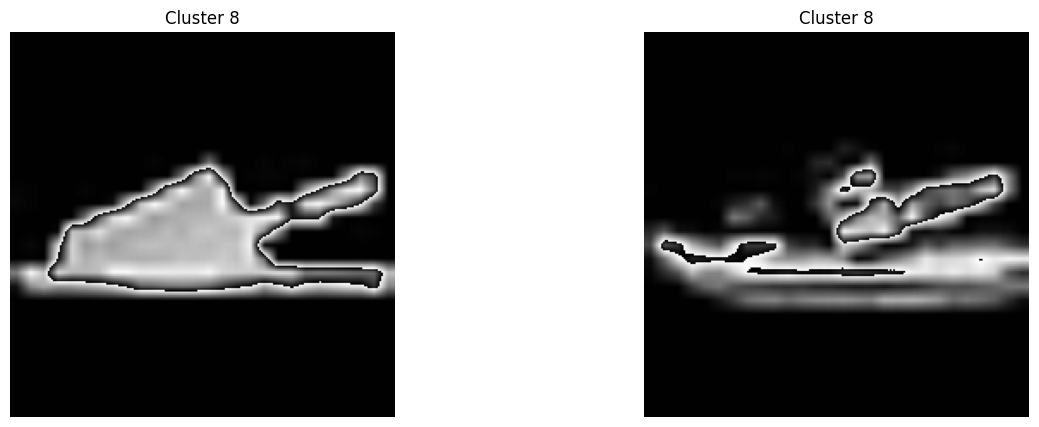

Displaying images for Cluster 13:


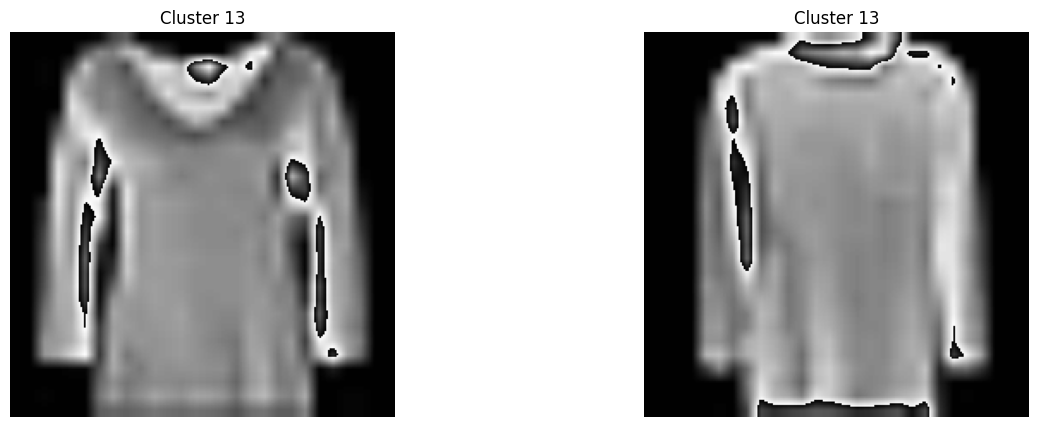

Displaying images for Cluster 28:


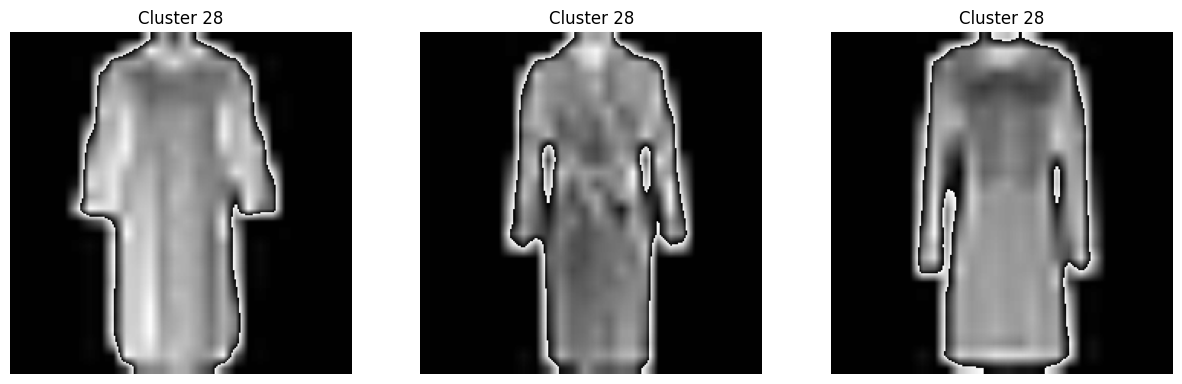

Displaying images for Cluster 5:


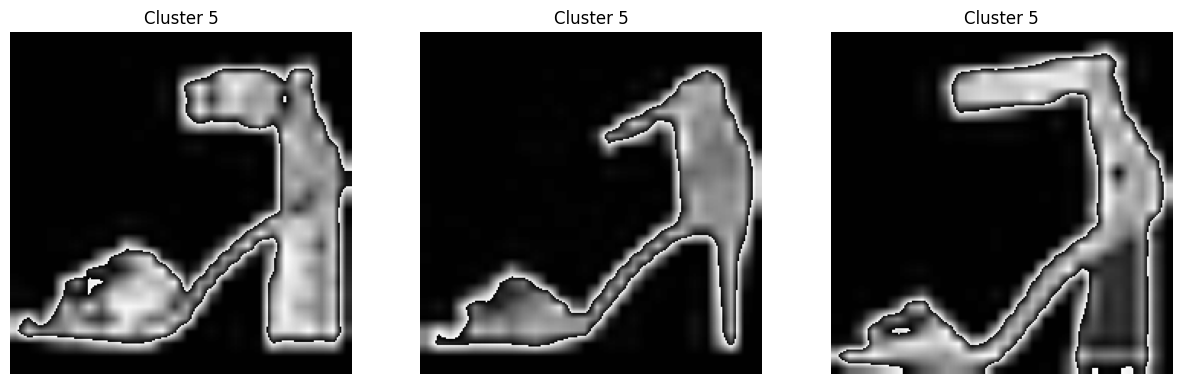

Displaying images for Cluster 3:


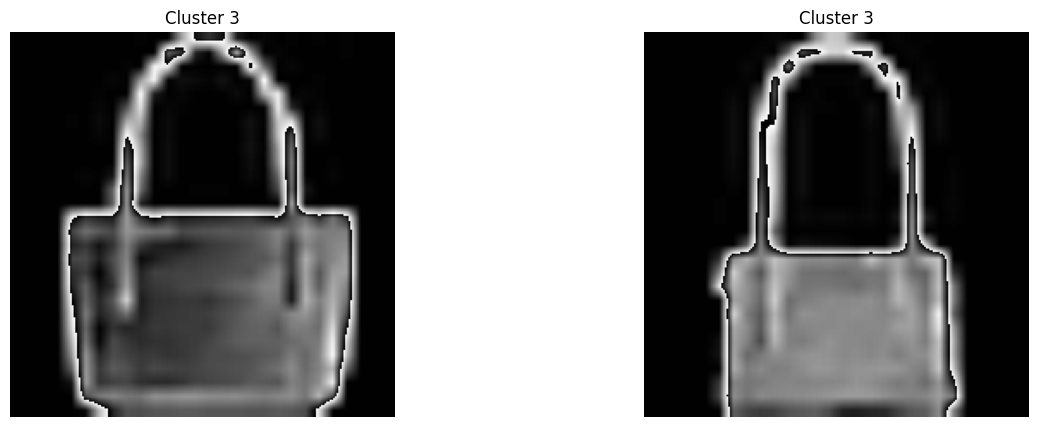

Displaying images for Cluster 24:


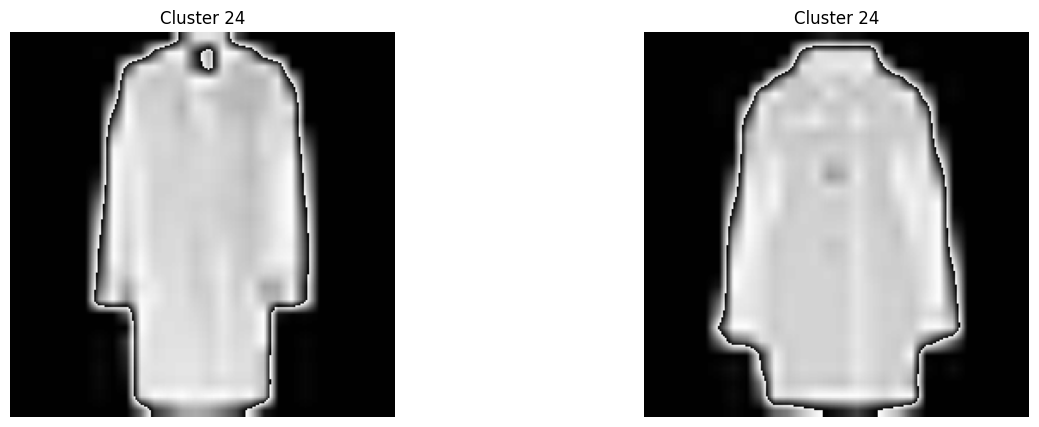

Displaying images for Cluster 23:


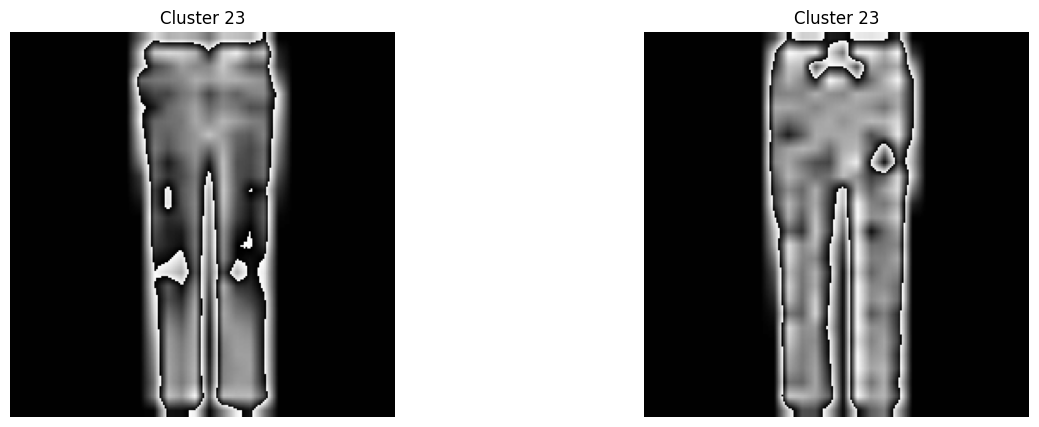

In [17]:
# Show images for each detected cluster
for cluster_id in clusters:
    display_cluster_images(cluster_id)